# Data Import

In [0]:
api_token = ... #REDACTED
import json
import zipfile
import os

!mkdir ~/.kaggle
!cd ~/.kaggle
!touch kaggle.json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

In [0]:
!mkdir content
!kaggle datasets download rouzbehm/jigsawdataset -p content
!ls content


os.chdir('content')
for file in os.listdir():
    zip_ref = zipfile.ZipFile(file, 'r')
    zip_ref.extractall()
    zip_ref.close()

 80% 39.0M/48.9M [00:00<00:00, 75.1MB/s]
100% 48.9M/48.9M [00:00<00:00, 99.5MB/s]
jigsawdataset.zip


# Environment Setup

In [0]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt

import multiprocessing
from joblib import Parallel, delayed
import nltk
num_cores = multiprocessing.cpu_count()

from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
import datetime
from tqdm import tqdm

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.base import clone


In [0]:
complete_data = pd.read_csv("data.csv")
data = complete_data.copy()
targets = data.pop("unsafe").values

from sklearn.model_selection import train_test_split

train_data, test_data, train_targets, test_targets = train_test_split(data, targets, test_size = 0.1, random_state=123)
test_data, validation_data, test_targets, validation_targets = train_test_split(test_data, test_targets, test_size = 0.5, random_state=123)

In [0]:
def train_and_evaluate(clf, X_train, y_train, X_test, y_test, epochs=10):
    training_scores = []
    test_scores = []
    last_clf_state = None
    num_epochs_no_change = 0
    print("Starting training and test...")
    for i in range(1, epochs + 1):
        print("Epoch:" + str(i) + "/" + str(epochs) + " -- " + str(datetime.datetime.now()))
        print("\tTraining")
        clf.fit(X_train, y_train)
        training_score = clf.score(X_train, y_train)
        training_scores.append(training_score)
        print("\tTraining Done", training_score)
        
        print("\tTesting")
        clf.predict(X_test)
        test_score = clf.score(X_test, y_test)
        print("\tTest Done", test_score)

        if (len(test_scores) > 0 and test_score < test_scores[-1]):
          print("EARLY STOP: model overfitting")
          clf = last_clf_state
          test_scores.append(test_score)
          break
        elif (len(test_scores) > 0 and test_score == test_scores[-1]):
          num_epochs_no_change += 1
          test_scores.append(test_score)

          if num_epochs_no_change == 2:
            print("EARLY STOP: no change")
            break
        else:
          test_scores.append(test_score)
          last_clf_state = clone(clf)

    print("Done training and test.")
    return (training_scores,test_scores)

def plotScores(scores_train, scores_test,title=""):
    # Plot the points
    plt.plot([i + 1 for i in range(len(scores_train))], scores_train,marker='o')
    plt.plot([i + 1 for i in range(len(scores_test))], scores_test,marker='o')
    # Setup the legend
    plt.legend(["Train scores", "Test Scores"])
    plt.title(title)
    # Labels for the x and y axis
    plt.ylabel("Score")
    plt.xlabel("Epoch")
    plt.grid()
    plt.show()

# Baseline Classification
To begin classification, we must first preprocess the data to get it ready for training. A Count Vectorizer is used to do this

In [0]:
count_vect = CountVectorizer()
train_counts_vect = count_vect.fit_transform(train_data["comment_text"])
test_counts_vect = count_vect.transform(test_data["comment_text"])

print(list(count_vect.vocabulary_.items())[:10])

[('by', 26060), ('far', 53687), ('the', 140556), ('coolest', 35349), ('story', 135134), ('ve', 150264), ('read', 116983), ('in', 72303), ('long', 85968), ('time', 142033)]


In [0]:
tfid_vect = TfidfVectorizer()
train_tfid_vect = tfid_vect.fit_transform(train_data["comment_text"])
test_tfid_vect = tfid_vect.transform(test_data["comment_text"])

print(list(tfid_vect.vocabulary_.items())[:10])

[('by', 26060), ('far', 53687), ('the', 140556), ('coolest', 35349), ('story', 135134), ('ve', 150264), ('read', 116983), ('in', 72303), ('long', 85968), ('time', 142033)]


In [0]:
clf_count = LogisticRegression(solver='lbfgs', max_iter=2000, random_state=123, n_jobs=-1, warm_start=True)

In [0]:
clf_log_scores = train_and_evaluate(clf_count, train_counts_vect, train_targets, test_counts_vect, test_targets)

Starting training and test...
Epoch:1/10 -- 2019-11-29 15:48:36.679274
	Training
	Training Done 0.9166864807194025
	Testing
	Test Done 0.8678189300411523
Epoch:2/10 -- 2019-11-29 15:50:50.520440
	Training
	Training Done 0.9166895290352081
	Testing
	Test Done 0.8678189300411523
Epoch:3/10 -- 2019-11-29 15:50:53.152960
	Training
	Training Done 0.9166895290352081
	Testing
	Test Done 0.8678189300411523
EARLY STOP: no change
Done training and test.


In [0]:
clf_tfidf = LogisticRegression(solver='lbfgs', max_iter=2000, random_state=123, warm_start=True, n_jobs=-1)

In [0]:
clf_log_scores_tfid = train_and_evaluate(clf_tfidf, train_tfid_vect, train_targets, test_tfid_vect, test_targets)

Starting training and test...
Epoch:1/10 -- 2019-11-29 20:46:24.266855
	Training
	Training Done 0.8901539399481786
	Testing
	Test Done 0.8705075445816186
Epoch:2/10 -- 2019-11-29 20:46:47.115314
	Training
	Training Done 0.8901508916323732
	Testing
	Test Done 0.8705075445816186
Epoch:3/10 -- 2019-11-29 20:46:48.974640
	Training
	Training Done 0.8901539399481786
	Testing
	Test Done 0.8705075445816186
EARLY STOP: no change
Done training and test.


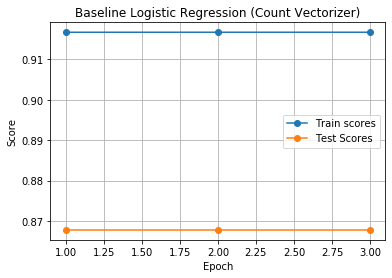

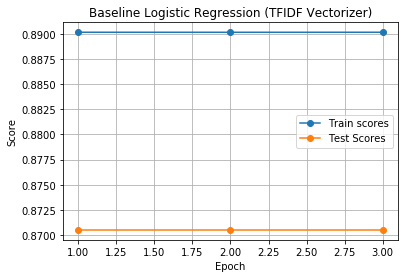

In [0]:
plotScores(clf_log_scores[0],clf_log_scores[1],"Baseline Logistic Regression (Count Vectorizer)")
plotScores(clf_log_scores_tfid[0],clf_log_scores_tfid[1],"Baseline Logistic Regression (TFIDF Vectorizer)")

It seems that the TFIDF vectorizer performed slightly better than the Count Vectorizer. We will focus our efforts on using the TFIDF vectorizer for later networks.

In [0]:
clf_tfidf_pred = clf_tfidf.predict(test_tfid_vect)

In [0]:
clf_tfidf_acc = accuracy_score(test_targets, clf_tfidf_pred)
clf_tfidf_precision_safe = precision_score(test_targets, clf_tfidf_pred)
clf_tfidf_recall = recall_score(test_targets, clf_tfidf_pred)
clf_tfidf_f1 = f1_score(test_targets, clf_tfidf_pred)

print("Accuracy:", clf_tfidf_acc)
print("Precision:",clf_tfidf_precision_safe)
print("Recall:",clf_tfidf_recall)
print("F1 Score:",clf_tfidf_f1)

Accuracy: 0.8705075445816186
Precision: 0.8892239879364343
Recall: 0.8451107926358725
F1 Score: 0.8666063757630568


In [0]:
from sklearn.metrics import precision_recall_fscore_support

scores = precision_recall_fscore_support(test_targets,clf_tfidf_pred)
print("Precision:")
print("\tSafe:", scores[0][0])
print("\tUnsafe:", scores[0][1])
print("Recall:")
print("\tSafe:", scores[1][0])
print("\tUnsafe:", scores[1][1])
print("F1 Score:")
print("\tSafe:", scores[2][0])
print("\tUnsafe:", scores[2][1])
print("Support:")
print("\tSafe:", scores[3][0])
print("\tUnsafe:", scores[3][1])

Precision:
	Safe: 0.8537067888379841
	Unsafe: 0.8892239879364343
Recall:
	Safe: 0.8956740222853398
	Unsafe: 0.8451107926358725
F1 Score:
	Safe: 0.8741870135408891
	Unsafe: 0.8666063757630568
Support:
	Safe: 9154
	Unsafe: 9071


In [0]:
clf_mlp = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(50), random_state=123, max_iter=150, warm_start=True, activation='logistic',early_stopping=True)

In [0]:
train_scores_mlp, test_scores_mlp = train_and_evaluate(clf_mlp, train_counts_vect, train_targets,test_counts_vect,test_targets)

Starting training and test...
Epoch:1/10 -- 2019-11-29 16:21:13.192428
	Training
	Training Done 0.89964639536656
	Testing
	Test Done 0.8770919067215364
Epoch:2/10 -- 2019-11-29 16:26:39.792675
	Training
	Training Done 0.9323487273281512
	Testing
	Test Done 0.8771467764060357
Epoch:3/10 -- 2019-11-29 16:31:58.282782
	Training
	Training Done 0.9607864654778235
	Testing
	Test Done 0.8669958847736625
EARLY STOP: model overfitting
Done training and test.


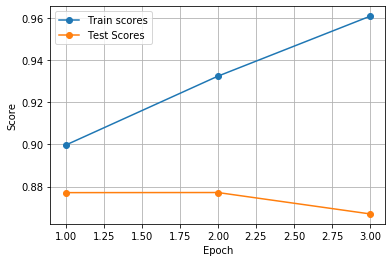

In [0]:
plotScores(train_scores_mlp,test_scores_mlp)

In [0]:
clf_mlp_counts_pred = clf_mlp.predict(test_tfid_vect)

In [0]:
clf_counts_acc = accuracy_score(test_targets, clf_mlp_counts_pred)
clf_counts_precision = precision_score(test_targets, clf_mlp_counts_pred)
clf_counts_recall = recall_score(test_targets, clf_mlp_counts_pred)
clf_counts_f1 = f1_score(test_targets, clf_mlp_counts_pred)

print("Accuracy:", clf_counts_acc)
print("Precision:",clf_counts_precision)
print("Recall:",clf_counts_recall)
print("F1 Score:",clf_counts_f1)

Accuracy: 0.8150342935528121
Precision: 0.9394079555966698
Recall: 0.6717010252452872
F1 Score: 0.7833129780806067


In [0]:
clf_mlp_tfidf = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(50), random_state=123, max_iter=150, warm_start=True, activation='logistic',early_stopping=True)

In [0]:
train_scores_mlp_tfidf, test_scores_mlp_tfidf = train_and_evaluate(clf_mlp_tfidf, train_tfid_vect, train_targets,test_tfid_vect,test_targets)

Starting training and test...
Epoch:1/10 -- 2019-11-29 16:37:18.717135
	Training
	Training Done 0.8905502210028959
	Testing
	Test Done 0.8745679012345678
Epoch:2/10 -- 2019-11-29 16:42:27.862152
	Training
	Training Done 0.9228014022252705
	Testing
	Test Done 0.8766529492455418
Epoch:3/10 -- 2019-11-29 16:47:51.662544
	Training
	Training Done 0.9405395518975765
	Testing
	Test Done 0.8684224965706447
EARLY STOP: model overfitting
Done training and test.


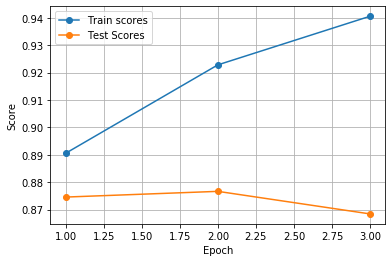

In [0]:
plotScores(train_scores_mlp_tfidf,test_scores_mlp_tfidf)

In [0]:
clf_mlp_tfidf_pred = clf_mlp_tfidf.predict(test_tfid_vect)

In [0]:
clf_tfidf_acc = accuracy_score(test_targets, clf_mlp_tfidf_pred)
clf_tfidf_precision = precision_score(test_targets, clf_mlp_tfidf_pred)
clf_tfidf_recall = recall_score(test_targets, clf_mlp_tfidf_pred)
clf_tfidf_f1 = f1_score(test_targets, clf_mlp_tfidf_pred)

print("Accuracy:", clf_tfidf_acc)
print("Precision:",clf_tfidf_precision)
print("Recall:",clf_tfidf_recall)
print("F1 Score:",clf_tfidf_f1)

Accuracy: 0.8684224965706447
Precision: 0.8676584022038567
Recall: 0.8680410098114871
F1 Score: 0.8678496638377603


We can see that during the 2nd epoch the test score slightly increased. However by the 3rd epoch the score once again went down, even though the training score greatly increased. This indicates that the model is starting to overfit by the 3rd epoch

We'll start our experimentation by creating two setup functions, one returns a Logistic Regression Model and one returns a MLP model. This way we can keep our settings consistent across different techniques.

In [0]:
def logistic_model():
  return LogisticRegression(solver='lbfgs', max_iter=2000, random_state=123, warm_start=True, n_jobs=-1,tol=1e-6)

def mlp_model():
  return MLPClassifier(solver='lbfgs', hidden_layer_sizes=(50), random_state=123, max_iter=150, warm_start=True, activation='logistic',early_stopping=True, learning_rate='adaptive')

def vectorize(train_data, test_data):
  tfid_vect = TfidfVectorizer()
  train_tfid_vect = tfid_vect.fit_transform(train_data)
  test_tfid_vect = tfid_vect.transform(test_data)
  return train_tfid_vect, test_tfid_vect

def score(predictions, targets=test_targets):
  acc = accuracy_score(targets, predictions)
  precision = precision_score(targets, predictions)
  recall = recall_score(targets, predictions)
  f1 = f1_score(targets, predictions)

  print("Accuracy:", acc)
  print("Precision:",precision)
  print("Recall:",recall)
  print("F1 Score:",f1)

  return (acc,precision,recall,f1)

# Natural Language Processing 

Now that we've established a baseline, we can start perfoming some natural language processing techniques on our text. Since we are judging the toxicity of a comment. It might help to "clean" up our data, for example we can remove non-alphanumeric characters. Essentially words that do not add a significant amount of additional information.

In [0]:
from nltk import word_tokenize
nltk.download('punkt')
import re

[nltk_data] Downloading package punkt to /Users/rouzbeh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## NLP Pipeline (Alphanumeric Only)
To remove non alphanumerics we can use the following regex pattern `^[a-zA-Z]+$`. We'll first try this setup on a single comment and then generalize for all comments. The first step to doing this will be to tokenize the comments, we can then remove words that do not match the alphanumeric only regex pattern.

In [0]:
no_alpha_comment_test = train_data.iloc[0]["comment_text"]
print(no_alpha_comment_test)

no_alpha_comment_test_tok = word_tokenize(no_alpha_comment_test.lower())
print(no_alpha_comment_test_tok)

no_alpha_comment_test_tok = [tok for tok in no_alpha_comment_test_tok if re.match("^[a-zA-Z]+$", tok)]
print(no_alpha_comment_test_tok)

no_alpha_comment_test_text = " ".join(no_alpha_comment_test_tok)
print(no_alpha_comment_test_text)

By far the coolest story I've read in a long, long time. It would be so awesome if they found life on another planet... hopefully it would give Earth something positive to focus on... instead of blowing ourselves up. 


.
['by', 'far', 'the', 'coolest', 'story', 'i', "'ve", 'read', 'in', 'a', 'long', ',', 'long', 'time', '.', 'it', 'would', 'be', 'so', 'awesome', 'if', 'they', 'found', 'life', 'on', 'another', 'planet', '...', 'hopefully', 'it', 'would', 'give', 'earth', 'something', 'positive', 'to', 'focus', 'on', '...', 'instead', 'of', 'blowing', 'ourselves', 'up', '.', '.']
['by', 'far', 'the', 'coolest', 'story', 'i', 'read', 'in', 'a', 'long', 'long', 'time', 'it', 'would', 'be', 'so', 'awesome', 'if', 'they', 'found', 'life', 'on', 'another', 'planet', 'hopefully', 'it', 'would', 'give', 'earth', 'something', 'positive', 'to', 'focus', 'on', 'instead', 'of', 'blowing', 'ourselves', 'up']
by far the coolest story i read in a long long time it would be so awesome if they found li

This process is helpful since it removed a lot of the less meaningful data. Which allows our model to focus on the more important information and context of the comment. We can now define a more general function that can be applied to all of our comments

In [0]:
def remove_non_alphanum(comment):
    comment_tok = word_tokenize(comment)

    comment_alpha = [tok for tok in comment_tok if re.match("^[a-zA-Z]+$", tok)]

    comment_text = " ".join(comment_alpha)
    return comment_text

def no_alpnum(comments, parallel=True):

    if parallel:
      new_comments = Parallel(n_jobs=num_cores)(delayed(remove_non_alphanum)(comment)for comment in tqdm(comments,position=0))
    else:
      new_comments = []
      for comment in tqdm(comments, position=0, leave=True):


          new_comments.append(comment_text)

    return np.array(new_comments)

In [0]:
train_data_alpha = no_alpnum(train_data["comment_text"])
test_data_alpha = no_alpnum(test_data["comment_text"])

100%|██████████| 18225/18225 [00:03<00:00, 4580.15it/s]


In [0]:
train_tfid_vect_alpha,test_tfid_vect_alpha = vectorize(train_data_alpha,test_data_alpha)

In [0]:
clf_alpha = LogisticRegression(solver='lbfgs', max_iter=2000, random_state=123, warm_start=True, n_jobs=-1, tol=1e-6)
clf_log_alpha_scores = train_and_evaluate(clf_alpha, train_tfid_vect_alpha, train_targets,test_tfid_vect_alpha,test_targets)

Starting training and test...
Epoch:1/10 -- 2019-11-27 14:46:02.733114
	Training
	Training Done 0.8871147690900777
	Testing
	Test Done 0.8679286694101509
Epoch:2/10 -- 2019-11-27 14:46:17.083787
	Training
	Training Done 0.8871117207742722
	Testing
	Test Done 0.8679286694101509
Epoch:3/10 -- 2019-11-27 14:46:18.483195
	Training
	Training Done 0.8871147690900777
	Testing
	Test Done 0.8679286694101509
EARLY STOP: no change
Done training and test.


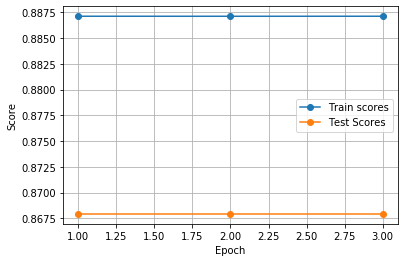

In [0]:
plotScores(clf_log_alpha_scores[0],clf_log_alpha_scores[1])

In [0]:
clf_log_alpha_pred = clf_alpha.predict(test_tfid_vect_alpha)

In [0]:
clf_log_alpha_results = score(clf_log_alpha_pred)

Accuracy: 0.8679286694101509
Precision: 0.8889796871351856
Recall: 0.8394884797706978
F1 Score: 0.8635255428927823


In [0]:
clf_mlp_alpha = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(50), random_state=123, max_iter=150, warm_start=True, activation='logistic',early_stopping=True, learning_rate='adaptive')
train_scores_mlp_alpha, test_scores_mlp_alpha = train_and_evaluate(clf_mlp_alpha, train_tfid_vect_alpha, train_targets,test_tfid_vect_alpha,test_targets)

Starting training and test...
Epoch:1/10 -- 2019-11-27 14:46:20.089650
	Training
	Training Done 0.8861515012955342
	Testing
	Test Done 0.8694101508916324
Epoch:2/10 -- 2019-11-27 14:50:30.974732
	Training
	Training Done 0.9040877914951989
	Testing
	Test Done 0.8734156378600823
Epoch:3/10 -- 2019-11-27 14:52:56.843876
	Training
	Training Done 0.9311172077427221
	Testing
	Test Done 0.8629355281207133
EARLY STOP: model overfitting
Done training and test.


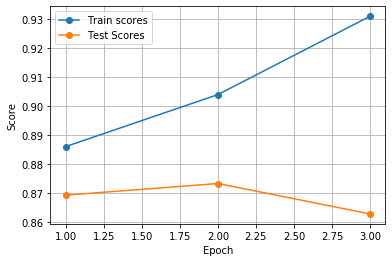

In [0]:
plotScores(train_scores_mlp_alpha,test_scores_mlp_alpha)

In [0]:
clf_mlp_alpha_pred = clf_mlp_alpha.predict(test_tfid_vect_alpha)

In [0]:
clf_mlp_alpha_results = score(clf_mlp_alpha_pred)

Accuracy: 0.8629355281207133
Precision: 0.8671656798123115
Recall: 0.8556939697938485
F1 Score: 0.8613916324492287


## NLP Pipeline (Stopword removal)
Another NLP method we can possibly apply to the comments is stopword removal. Generally stopwords do not contain significant information and can be removed, thus increasing processing speeds. To do this we will use the NLTK library.

In [0]:
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rouzbeh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
def remove_stopword(comment):
  comment_tok = word_tokenize(comment)
  filtered_comment_tok = [w for w in comment_tok if not w in stopwords.words('english')] 
  comment_text = " ".join(filtered_comment_tok)
  return comment_text


def no_stopword(comments):
    new_comments = Parallel(n_jobs=num_cores)(delayed(remove_stopword)(comment)for comment in tqdm(comments,position=0))

    return np.array(new_comments)

In [0]:
train_data_stopwords = no_stopword(train_data["comment_text"])
test_data_stopwords = no_stopword(test_data["comment_text"])

100%|██████████| 18225/18225 [00:33<00:00, 543.27it/s]


In [0]:
train_data_stopwords

array(["By far coolest story I 've read long , long time . It would awesome found life another planet ... hopefully would give Earth something positive focus ... instead blowing . .",
       "trump PLUMMETING polls . Nobody wants guy . He 's like old fish . Throw bath water . He abuses women wife naked internet . BAD NEWS ! ! !",
       "`` Sanity check Looking paragraph ... `` '' Before 1960s , news media interest Vietnam . Black American journalists followed events breaking news happened region . '' '' I know nothing subject matter ( hence reading article ) really relating specifically Black journalists ? Or someone vandalised ? If 's accurate , Black journalists special opposed rest ? Again I n't know I 'd imagine considerable minority point ? 86.174.184.73 ``",
       ...,
       "Yes ... I resources means make life miserable people I n't like ... livelihood ... .",
       'Perhaps something fact predominately black countries violent mess , blacks involved gangs shootings across US

In [0]:
train_counts_vect_stopwords,test_counts_vect_stopwords = vectorize(train_data_stopwords,test_data_stopwords)

In [0]:
clf_stopwords = LogisticRegression(solver='lbfgs', max_iter=2000, random_state=123, warm_start=True)
clf_log_stopwords_scores = train_and_evaluate(clf_stopwords, train_counts_vect_stopwords, train_targets, test_counts_vect_stopwords, test_targets, 10)

Starting training and test...
Epoch:1/10 -- 2019-11-27 16:50:17.466417
	Training
	Training Done 0.8910440481633898
	Testing
	Test Done 0.8700137174211249
Epoch:2/10 -- 2019-11-27 16:50:35.598054
	Training
	Training Done 0.8910349032159732
	Testing
	Test Done 0.8700137174211249
Epoch:3/10 -- 2019-11-27 16:50:35.970882
	Training
	Training Done 0.8910440481633898
	Testing
	Test Done 0.8700137174211249
EARLY STOP: no change
Done training and test.


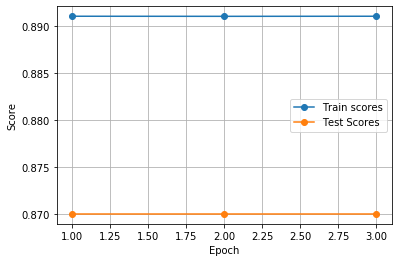

In [0]:
plotScores(clf_log_stopwords_scores[0],clf_log_stopwords_scores[1])

In [0]:
clf_log_stopwords_pred = clf_stopwords.predict(test_counts_vect_stopwords)

In [0]:
clf_log_stopwords_results = score(clf_log_stopwords_pred)

Accuracy: 0.8700137174211249
Precision: 0.8901956217978575
Recall: 0.8427957226325653
F1 Score: 0.865847443230081


In [0]:
clf_mlp_stopwords = MLPClassifier(solver='lbfgs', alpha=1e-4, hidden_layer_sizes=(50), random_state=123, max_iter=150, learning_rate_init=0.1, warm_start=True)
train_scores_mlp_stopwords, test_scores_mlp_stopwords = train_and_evaluate(clf_mlp_stopwords, train_counts_vect_stopwords, train_targets,test_counts_vect_stopwords,test_targets,5)

Starting training and test...
Epoch:1/5 -- 2019-11-27 16:50:36.650175
	Training
	Training Done 0.8847340344459687
	Testing
	Test Done 0.8698491083676269
Epoch:2/5 -- 2019-11-27 16:52:50.370284
	Training
	Training Done 0.8847340344459687
	Testing
	Test Done 0.8698491083676269
Epoch:3/5 -- 2019-11-27 16:52:59.513681
	Training
	Training Done 0.8847340344459687
	Testing
	Test Done 0.8698491083676269
EARLY STOP: no change
Done training and test.


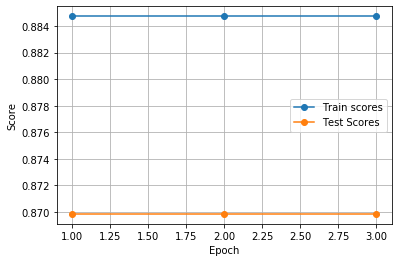

In [0]:
plotScores(train_scores_mlp_stopwords,test_scores_mlp_stopwords)

In [0]:
clf_mlp_stopwords_pred = clf_mlp_stopwords.predict(test_counts_vect_stopwords)

In [0]:
clf_mlp_stopwords_results = score(clf_mlp_stopwords_pred)

Accuracy: 0.8698491083676269
Precision: 0.8897033158813263
Recall: 0.8430162054900231
F1 Score: 0.8657307822936713


## NLP Pipeline (Nouns Only)
Additionally we can use NLTK to perform Part of Speech (POS) tagging. Once this is done we can keep words labelled as nouns. This may be a useful method of preprocessing before classification as adjectives typically contain significant setiment information. In order to do this we once again first tokenize the comment, then perform POS tagging, finally filtering out words that are not tagged as nouns (start with 'n'). 

In [0]:
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

from nltk.stem.wordnet import WordNetLemmatizer

[nltk_data] Downloading package wordnet to /Users/rouzbeh/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/rouzbeh/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [0]:
from nltk.corpus import wordnet

def noun_only_comment(comment):
    comment_tokens = word_tokenize(comment)

    posTokens = nltk.pos_tag(comment_tokens)

    noun_only_comment = [tok[0] for tok in posTokens if tok[1][0] == 'N']
    
    comment_text = " ".join(noun_only_comment)
    return comment_text

def noun_only_comments(comments, parallel=True):
  if parallel:
    new_comments = Parallel(n_jobs=num_cores)(delayed(noun_only_comment)(comment)for comment in tqdm(comments,position=0))
  else:
    new_comments = []
    for comment in tqdm(comments, position=0):
      new_comment = adj_only_comment(comment)
      new_comments.append(new_comment)

  return np.array(new_comments)

In [0]:
print(train_data.iloc[42]["comment_text"])
print(noun_only_comment(train_data.iloc[42]["comment_text"]))

Fuck Femenism!!!! If women want to show their tits,  men can look. Y'all are startin' to sound like a damn church ladies group or something. Are you trying to get on the front page of the Weslyn Methodist Magazine or what? Grow up and get a life!!
Fuck Femenism women tits men church ladies group something Are page Weslyn Methodist Magazine life


In [0]:
train_data_noun = noun_only_comments(train_data["comment_text"])
test_data_noun = noun_only_comments(test_data["comment_text"])

100%|██████████| 18225/18225 [00:12<00:00, 1441.73it/s]


In [0]:
tfidf_vect_noun = TfidfVectorizer()
train_counts_vect_noun = tfidf_vect_noun.fit_transform(train_data_noun)
test_counts_vect_noun = tfidf_vect_noun.transform(test_data_noun)

In [0]:
clf_noun = LogisticRegression(solver='lbfgs', max_iter=2000, random_state=123, warm_start=True)
clf_log_noun_scores = train_and_evaluate(clf_noun, train_counts_vect_noun, train_targets, test_counts_vect_noun, test_targets, 10)

Starting training and test...
Epoch:1/10 -- 2019-11-27 15:15:27.043733
	Training
	Training Done 0.8105868007925621
	Testing
	Test Done 0.7877640603566529
Epoch:2/10 -- 2019-11-27 15:15:43.036063
	Training
	Training Done 0.810562414266118
	Testing
	Test Done 0.7877640603566529
Epoch:3/10 -- 2019-11-27 15:15:43.423929
	Training
	Training Done 0.8105654625819235
	Testing
	Test Done 0.7877640603566529
EARLY STOP: no change
Done training and test.


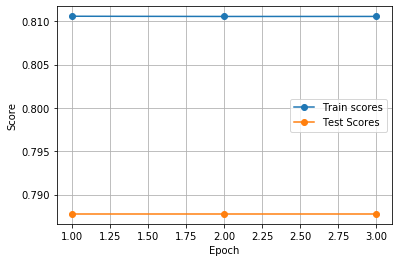

In [0]:
plotScores(clf_log_noun_scores[0],clf_log_noun_scores[1])

In [0]:
clf_log_noun_pred = clf_noun.predict(test_counts_vect_noun)

In [0]:
clf_log_noun_results = score(clf_log_noun_pred)

Accuracy: 0.7877640603566529
Precision: 0.8240129530452112
Recall: 0.7293572924705104
F1 Score: 0.7738011695906433


In [0]:
clf_mlp_noun = MLPClassifier(solver='lbfgs', alpha=1e-4, hidden_layer_sizes=(50), random_state=123, max_iter=150, learning_rate_init=0.1, warm_start=True)
train_scores_mlp_noun, test_scores_mlp_noun = train_and_evaluate(clf_mlp_noun, train_counts_vect_noun, train_targets,test_counts_vect_noun,test_targets,5)

Starting training and test...
Epoch:1/5 -- 2019-11-27 15:15:44.394488
	Training
	Training Done 0.8006340496875476
	Testing
	Test Done 0.7840877914951989
Epoch:2/5 -- 2019-11-27 15:18:27.297457
	Training
	Training Done 0.8137844840725499
	Testing
	Test Done 0.7886968449931413
Epoch:3/5 -- 2019-11-27 15:19:45.380535
	Training
	Training Done 0.843304374333181
	Testing
	Test Done 0.7708641975308642
EARLY STOP: model overfitting
Done training and test.


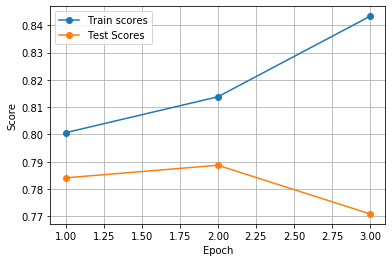

In [0]:
plotScores(train_scores_mlp_noun,test_scores_mlp_noun)

In [0]:
clf_mlp_noun_pred = clf_mlp_noun.predict(test_counts_vect_noun)

In [0]:
clf_mlp_noun_results = score(clf_mlp_noun_pred)

Accuracy: 0.7708641975308642
Precision: 0.7850238732968441
Recall: 0.743137471061625
F1 Score: 0.763506625891947


We can see that by epoch 2 the the test score has peaked at around 78.8%. After that the model train score continuously increases while the test score decreases, this is a symptom overfitting. However our train and evaluate function detects this, automatically stops training and returns 

# Results

Our results can be summarized in the following table

|Model|Accuracy|Precision|Recall|F1 Score|
|-----|--------|---------|------|--------|
|Logistic Regression (Baseline)|0.870507|0.889223|0.845110|0.866606|
|MLP (Baseline)|0.868422|0.867658|0.868041|0.867849|
|Logistic Regression (Alphanumeric only)|0.867928|0.888979|0.839488|0.863525|
|MLP (Alphanumeric only)|0.862935|0.867165|0.855693|0.861391|
|Logistic Regression (No Stopwords)|0.870013|0.890195|0.842795|0.865847|
|MLP (No Stopwords)|0.869849|0.889703|0.843016|0.865730|
|Logistic Regression (Nouns only)|0.787764|0.824012|0.729357|0.773801|
|MLP (Nouns only)|0.770864|0.785023|0.743137|0.763506|


We can see that the best accuracy was obtained by the Logistic Regression (Baseline) at 0.87 while the worst result was obtained by the MLP (Nouns only) 0.77. Interestingly the NLP methods did not change the results obtained after training. Overally the NLP techniques used, most specifically **no stopwords** would provide better results on much larger datasets for example a balanced data set with more than 1 million comments since there's already not alot of data for the neural network to learn.